In [2]:
import nibabel as nb 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Functional_Fusion.reliability import decompose_subj_group
import Functional_Fusion.util as ut
from scipy.stats import ttest_1samp

from scripts import decomposing_variances
from scripts import make_atlas
#from scripts import bold_normalization 
import Functional_Fusion.dataset as ds
import Functional_Fusion.atlas_map as am

/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_73870/2684524075.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
import os
import shutil

# --- Edit these paths ---
source_dir = '/path/to/source/folder'       # Folder where your beta_000X.nii files currently are
destination_dir = '/path/to/destination/folder'  # Folder you want to copy them into

# Create destination folder if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Loop over file numbers 1 through 240
for i in range(1, 241):
    # File names are like "beta_0001.nii", "beta_0023.nii", etc.
    filename = f"beta_{i:04d}.nii"   # zero-pads numbers to 4 digits
    
    src = os.path.join(source_dir, filename)
    dst = os.path.join(destination_dir, filename)
    
    # Copy the file
    if os.path.exists(src):
        shutil.copy(src, dst)
        print(f"Copied: {filename}")
    else:
        print(f"Missing: {filename}")


In [4]:
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion_new' 

data, info, ds_obj = ds.get_dataset(base_dir,'Pontine',atlas="MNISymThalamus1",sess='ses-s1', subj=None, 
                                type='CondRun')

In [13]:
data

info.task

0      1
1      2
2      3
3      4
4      5
      ..
139    5
140    6
141    7
142    8
143    9
Name: task, Length: 144, dtype: int64

In [2]:
atlas='MNISymCSF'
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion' 

pontine7T_data = ds.get_dataset(base_dir,'Pontine',atlas=atlas,type='CondRun',sess='ses-s1',subj=None)

cond_vec = np.tile(np.arange(1,10),16)

part_vec = np.repeat(np.arange(1,17), 9)

pontine7T_data = ds.remove_baseline(pontine7T_data[0], part_vec)

tensor_4d = decomposing_variances.flat2ndarray(pontine7T_data, cond_vec, part_vec)

#tensor_4d = decomposing_variances.flat2ndarray(pontine7T_data[0], cond_vec, part_vec)

print(tensor_4d.shape)

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group' 

np.save(wk_dir +'/Pontine7T_csf.npy', tensor_4d)


FileNotFoundError: No such file or no access: '/Volumes/diedrichsen_data$/data/FunctionalFusion/Pontine/derivatives/sub-98/data/sub-98_space-MNISymCSF_ses-s1_CondRun.dscalar.nii'

In [70]:
#loading prewhitened betas (form subjects x repetitions x conditions x voxels) for putting data into .tsv file

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/RegionOfInterest_BOLDMNI/data/group' #see README in this directory for explanation on .npy file generation

dentate_mdtb = np.load(wk_dir + '/MDTB_ses2_dentate.npy')
cereb_gray_mdtb = np.load(wk_dir + '/MDTB_ses2_cereb_gray.npy')
thalamus_mdtb = np.load(wk_dir + '/MDTB_ses2_thalamus.npy')
redn_mdtb = np.load(wk_dir + '/MDTB_ses2_redn.npy')
olive_mdtb = np.load(wk_dir + '/MDTB_ses2_olive.npy')
pontine_mdtb = np.load(wk_dir + '/MDTB_ses2_pontine.npy')



In [76]:
#data into .tsv files

data = olive_mdtb

data = np.nan_to_num(data)

n_subj, n_runs, n_conds, n_vox = data.shape

reshaped_data = data.reshape(n_subj, n_runs * n_conds, n_vox)   

cond_vec = np.tile(np.arange(1,33),16)

part_vec = np.repeat(np.arange(1,17), 32)

var_decomp = decompose_subj_group(reshaped_data, cond_vec, part_vec, separate = 'subject_wise', subtract_mean=False)

print(reshaped_data.shape)

var_norm = np.zeros((24,3))

for i in range(24): #number of rows 
    row_sum = np.sum(var_decomp[i])
    var_norm[i] = var_decomp[i]/row_sum

print(var_norm)

ff_base ='/Volumes/diedrichsen_data$/data/FunctionalFusion/MDTB'

tsv_file = pd.read_csv("var_decomp.tsv", sep="\t")

df_lang = pd.DataFrame(var_norm, columns=["group", "individual", "noise"])

T = pd.read_csv(f'{ff_base}/participants.tsv', sep = '\t')

subj = [i for i in T.participant_id]

df_lang["subj_id"] = subj  
df_lang["dataset"] = "MDTB_ses2"  
df_lang["atlas"] = "MNISymOlive1"  # You can modify this as well

# Save as .tsv file (tab-separated)
df_lang.to_csv("var_decomp.tsv", sep="\t", mode = 'a', index=False, header=False)



(24, 512, 1448)
[[ 1.94048729e-03  4.22112531e-03  9.93838387e-01]
 [ 3.17336365e-03 -3.40222468e-05  9.96860659e-01]
 [ 2.04763911e-03  9.10413647e-05  9.97861320e-01]
 [ 1.73997931e-03 -7.63070729e-03  1.00589073e+00]
 [ 8.60322361e-04  1.46005224e-02  9.84539155e-01]
 [ 1.65779166e-03  7.27457611e-03  9.91067632e-01]
 [ 2.78796420e-03  7.32557253e-03  9.89886463e-01]
 [ 2.02888449e-03  3.96781446e-03  9.94003301e-01]
 [ 1.85217638e-03 -5.85098692e-04  9.98732922e-01]
 [ 1.13869444e-03 -3.95518248e-03  1.00281649e+00]
 [ 3.25630465e-03 -9.48759431e-05  9.96838571e-01]
 [ 1.08530831e-03  8.88834313e-03  9.90026349e-01]
 [ 3.63978402e-03  9.19225142e-03  9.87167965e-01]
 [ 2.23639555e-03  1.20557941e-02  9.85707810e-01]
 [ 1.63441430e-03  9.74338483e-03  9.88622201e-01]
 [ 2.49798341e-03 -1.08810279e-03  9.98590119e-01]
 [ 1.83915710e-03 -6.02580545e-03  1.00418665e+00]
 [ 2.07427879e-03  3.20187933e-03  9.94723842e-01]
 [ 2.07324973e-03  8.77638067e-03  9.89150370e-01]
 [ 4.30237142e-

In [3]:
D = pd.read_csv('var_decomp.tsv',sep='\t')
D['within']=D.group+D.individual
# Rearrange dataframe into long format for easier plotting
T= D.melt(id_vars=['dataset','atlas','subj_id'],value_vars=['group','within'],var_name='vartype',value_name='variance')

In [7]:
# Set Figure style to talk on black background

rc = {'axes.facecolor': 'black',
 'axes.edgecolor': 'white',
 'axes.grid': False,
 'axes.axisbelow': 'line',
 'axes.labelcolor': 'white',
 'figure.facecolor': 'black',
 'text.color': 'white',
 'xtick.color': 'white',
 'ytick.color': 'white',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'patch.edgecolor': 'white',
 'patch.force_edgecolor': False,
 'image.cmap': 'viridis',
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': False,
 'axes.spines.top': False}
sns.set_style(rc=rc)

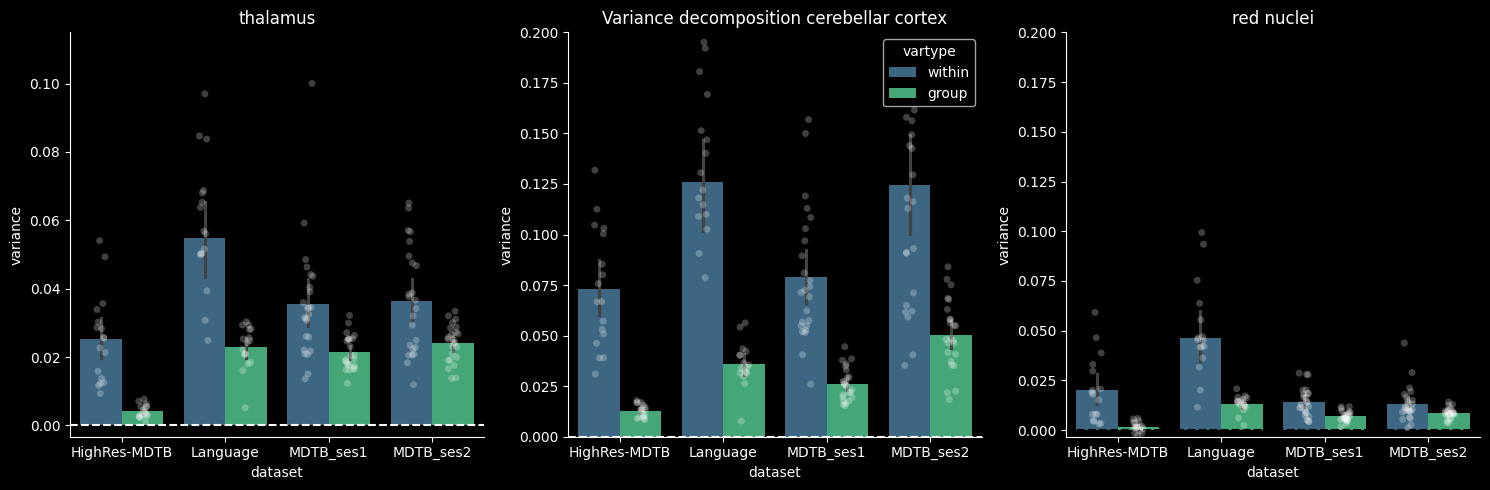

In [14]:
pal = [[1,1,1], [1,1,1]] #for black bgd

#pal = [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3]] #for white bgd


plt.figure(figsize=(15, 5)) 

# Thalamus
plt.subplot(1, 3, 1)
X = T[T.atlas == 'MNISymThalamus1']
ax = sns.barplot(data=X, x='dataset', y='variance', hue='vartype',
                 order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
                 hue_order=['within', 'group'], palette='viridis')
sns.stripplot(data=X, x='dataset', y='variance', hue='vartype',
              order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
              hue_order=['within', 'group'], 
              palette=pal, alpha=0.25, jitter=0.1,
              dodge=True, legend=False)
ax.axhline(0, color='white', linestyle='--')
ax.set_ylim(-0.0033, 0.115)
ax.set_title("thalamus")
ax.legend_.remove()

# Cerebellar Gray
plt.subplot(1, 3, 2)
X = T[T.atlas == 'MNISymCereb2']
ax = sns.barplot(data=X, x='dataset', y='variance', hue='vartype',
                 order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
                 hue_order=['within', 'group'], palette='viridis')
sns.stripplot(data=X, x='dataset', y='variance', hue='vartype',
              order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
              hue_order=['within', 'group'], palette=pal, alpha=0.25, jitter=0.1,
              dodge=True, legend=False)
plt.axhline(0, color='white', linestyle='--')
ax.set_ylim(0, 0.2)
ax.set_title("Variance decomposition cerebellar cortex")

# Dentate Nucleus (example third plot)
plt.subplot(1, 3, 3)
X = T[T.atlas == 'MNISymRedNucleus1']  # Change this to match your dentate label
ax = sns.barplot(data=X, x='dataset', y='variance', hue='vartype',
                 order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
                 hue_order=['within', 'group'], palette='viridis')
sns.stripplot(data=X, x='dataset', y='variance', hue='vartype',
              order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'],
              hue_order=['within', 'group'], palette=pal, alpha=0.25, jitter=0.1,
              dodge=True, legend=False)
plt.axhline(0, color='black', linestyle='--')
ax.set_ylim(-0.0033, 0.2)  # Adjust as needed
ax.set_title("red nuclei")
ax.legend_.remove()

plt.tight_layout()
plt.show()



#recall that the height of the bars is the MEAN of the subject group + individual values in the .tsv file


In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for thalamus
X = T[T.atlas == 'MNISymPontine1']

# Pivot to get columns: 'within' and 'group'
pivoted = X.pivot_table(index='dataset', columns='vartype', values='variance', aggfunc='mean').reset_index()

# Compute ratio = within / (within + group)
pivoted['ratio'] = pivoted['within'] / (pivoted['within'] + pivoted['group'])


/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_73870/2256193321.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pivoted, x='dataset', y='ratio', palette='viridis',


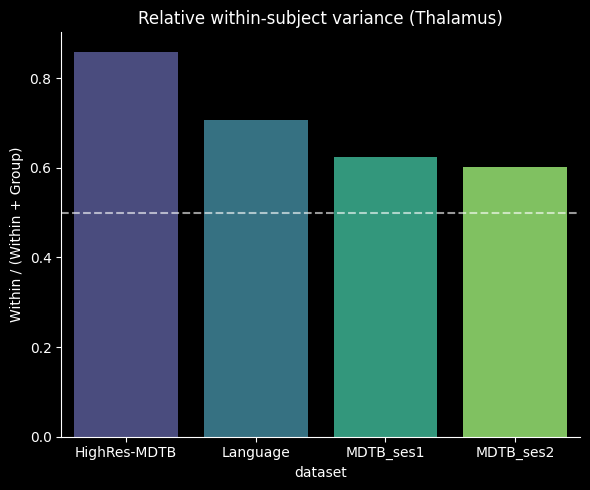

In [21]:
plt.figure(figsize=(6,5))
sns.barplot(data=pivoted, x='dataset', y='ratio', palette='viridis',
            order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2'])
plt.axhline(0.5, color='white', linestyle='--', alpha=0.6)
plt.ylabel('Within / (Within + Group)')
plt.title('Relative within-subject variance ()')
plt.tight_layout()
plt.show()


/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_73870/943722316.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


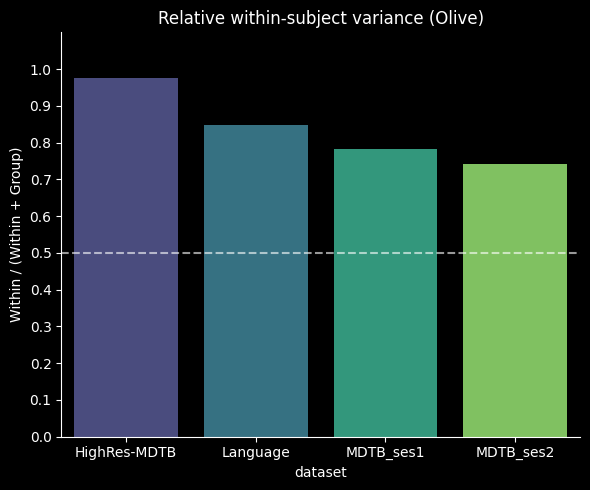

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.barplot(
    data=pivoted, 
    x='dataset', 
    y='ratio', 
    palette='viridis',
    order=['HighRes-MDTB', 'Language', 'MDTB_ses1', 'MDTB_ses2']
)

# Reference line
plt.axhline(0.5, color='white', linestyle='--', alpha=0.6)

# Labeling and ticks
plt.ylabel('Within / (Within + Group)')
plt.title('Relative within-subject variance (Pontine)')
plt.yticks(np.arange(0, 1.1, 0.1))  # from 0 to 0.8 in 0.1 increments
plt.ylim(0, 1.1)  # make sure the y-axis stops at 0.8

plt.tight_layout()
plt.show()


In [84]:
datasets = T['dataset'].unique()
atlases = T['atlas'].unique()
vartypes = ['within', 'group']

# Store results
print("=== One-sample t-tests against zero ===")
for atlas in atlases:
    print(f"\nAtlas: {atlas}")
    for ds in datasets:
        for vt in vartypes:
            # Get data for that combo
            data = T[(T['dataset'] == ds) & (T['vartype'] == vt) & (T['atlas'] == atlas)]['variance'].values
            if len(data) > 0:
                t_stat, p_val = ttest_1samp(data, 0)
                mean = data.mean()
                print(f"{ds} | {vt:6s} | mean = {mean:.4f}, t = {t_stat:.3f}, p = {p_val:.4e}, n = {len(data)}")


=== One-sample t-tests against zero ===

Atlas: MNISymDentate1
Language | within | mean = 0.0354, t = 6.689, p = 5.1987e-06, n = 17
Language | group  | mean = 0.0070, t = 8.675, p = 1.9093e-07, n = 17
HighRes-MDTB | within | mean = 0.0182, t = 6.383, p = 9.0681e-06, n = 17
HighRes-MDTB | group  | mean = 0.0015, t = 5.285, p = 7.4004e-05, n = 17
MDTB_ses1 | within | mean = 0.0097, t = 8.594, p = 1.2294e-08, n = 24
MDTB_ses1 | group  | mean = 0.0034, t = 9.579, p = 1.7118e-09, n = 24
MDTB_ses2 | within | mean = 0.0101, t = 6.519, p = 1.1884e-06, n = 24
MDTB_ses2 | group  | mean = 0.0053, t = 10.382, p = 3.7496e-10, n = 24

Atlas: MNISymCereb2
Language | within | mean = 0.1261, t = 10.623, p = 1.1770e-08, n = 17
Language | group  | mean = 0.0358, t = 13.615, p = 3.2348e-10, n = 17
HighRes-MDTB | within | mean = 0.0732, t = 10.234, p = 1.9877e-08, n = 17
HighRes-MDTB | group  | mean = 0.0130, t = 16.706, p = 1.5043e-11, n = 17
MDTB_ses1 | within | mean = 0.0788, t = 11.752, p = 3.3512e-11,